# Infilled Gas Assessment 

The purpose of this notebook is to compare the characteristics of key greenhouse gases to the institutional scenarios.

For questions about this notebook, please contact Gaurav Ganti <gaurav.ganti@climateanalytics.org>.

In [1]:
import os
import pyam 
import matplotlib.pyplot as plt 
import numpy as np 
import string 
from silicone.utils import convert_units_to_MtCO2_equiv
from scipy import stats

<IPython.core.display.Javascript object>

# Read in data 

In [2]:
infill_data_set = ['bp', 'shell', 'weo', 'equinor', 'ieasr15']

In [3]:
for i, source in enumerate(infill_data_set):
    source_path = os.path.join(
        '..','output','{}_infilled_data.xlsx'.format(source)
    )
    if i == 0:
        inst_data = pyam.IamDataFrame(source_path)
    else:
        inst_data = inst_data.append(
            pyam.IamDataFrame(source_path)
        )

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../output/bp_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/shell_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/weo_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/equinor_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/ieasr15_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators


In [4]:
inst_data = inst_data.filter(year = range(2010,2060,10))

In [5]:
sr15_unharm = pyam.IamDataFrame(
    os.path.join('..','data','sr15_data_extract.xlsx')
)

pyam.core - INFO: Reading file ../data/sr15_data_extract.xlsx
pyam.core - INFO: Reading meta indicators


In [6]:
sr15_data = pyam.IamDataFrame(
    #os.path.join('..','data','sr15_data_extract.xlsx')
    os.path.join('..','data','infilling_database.csv'),
    meta = sr15_unharm.meta
)

pyam.core - INFO: Reading file ../data/infilling_database.csv


# Test plot 

In [7]:
variable = 'Emissions|CO2|Energy and Industrial Processes'

In [8]:
filter_args = dict(
    df = sr15_data, 
    category = ['Below 1.5C','1.5C low overshoot', '1.5C high overshoot', 'Lower 2C', 'Higher 2C', 'Above 2C'],
    join_meta = True
)

In [9]:
rc = {
    'Below 1.5C' : '#7ebbae',
    '1.5C low overshoot' : '#99cfe0',
    '1.5C high overshoot' : '#828eac',
    'Lower 2C' : '#eebdab',
    'Higher 2C' : '#d86c67',
    'Above 2C' : 'grey'
}

In [10]:
marker_categories = [
    ('NZ2021', '^', 'red','IEA (NZE)'),
    ('SDS_2020', '^', 'black', 'IEA (SDS)'),
    ('Net_Zero', '*','red', 'BP (Net Zero)'),
    ('Rapid','*','black', 'BP (Rapid)'),
    ('Sky-1.5','s','black', 'Shell (Sky 1.5)'),
    ('Rebalance', '+', 'black', 'Equinor (Rebalance)')
]

In [11]:
def boxplot_of_variable(ax,variable, ylabel, years = [2020,2030,2050],mod='qrw', legend=False):

    _data = pyam.filter_by_meta(
        sr15_data.filter(variable = variable, region='World').timeseries(),
        **filter_args
    )

    _inst = inst_data.filter(variable = variable)

    groupby = _data.groupby('category')
    plot_cats = [
        'Below 1.5C','1.5C low overshoot', '1.5C high overshoot', 'Lower 2C', 'Higher 2C', 'Above 2C', 'foo'
    ]
    _cats = len(plot_cats) - 1
    w = 0.6 / _cats

    for i, name in enumerate(plot_cats):
        if name not in groupby.groups:
            for scen, marker, color,label in marker_categories:
                _scen = _inst.filter(scenario=scen, model=mod).timeseries()
                for j, y in enumerate(years):
                    pos = pos = (0.75 / _cats * (i - _cats / 2) + j)
                    _pt = _scen[y].values[0]
                    ax.scatter(
                        x = pos, y = _pt, s=100, label=None, alpha=0.5,
                        marker = marker, color=color 
                    )
                ax.scatter(x=[], y=[],marker = marker, color=color, s=100, label=label,alpha=0.5)
        else:
            _df = groupby.get_group(name)
            c = rc[name]
            for j, y in enumerate(years):
                lst = _df[y][~np.isnan(_df[y])]
                pos = (0.75 / _cats * (i - _cats / 2) + j)
                p = ax.boxplot(lst, positions=[pos], widths=w * .90,
                                        whis=[0,100], sym='',
                                        patch_artist=True)
                ax.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=True if len([2010, 2030, 2050]) > 1 else False
                )
                plt.setp(p['boxes'], color=c)
                plt.setp(p['medians'], color='black')

            ax.plot([], c=c, label='{} [{}]'.format(name, len(_df)))

        ax.set_xlim(-0.6, (len(years) - 0.4))
        ax.set_xticks(range(0, len(years)))
        ax.set_xticklabels(years)
        if legend:
            ax.legend(ncol=1, bbox_to_anchor = (1.1, 0.8))
       
    ax.grid(alpha=0.3)
    ax.set_ylabel(ylabel)

In [12]:
vars_to_plot = [
    ('Emissions|CO2|Energy and Industrial Processes', 'Emissions (Mt CO$_2$ / yr)', 'CO$_2$ Energy and Industrial Process'),
    ('Emissions|CO2|AFOLU', 'Emissions (Mt CO$_2$ / yr)', 'CO$_2$ AFOLU'),
    ('Emissions|CH4', 'Emissions (Mt CH$_4$ / yr)', 'CH$_4$'),
    ('Emissions|N2O', 'Emissions (kt N$_2$O / yr)', 'N$_2$O')
]

In [13]:
import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

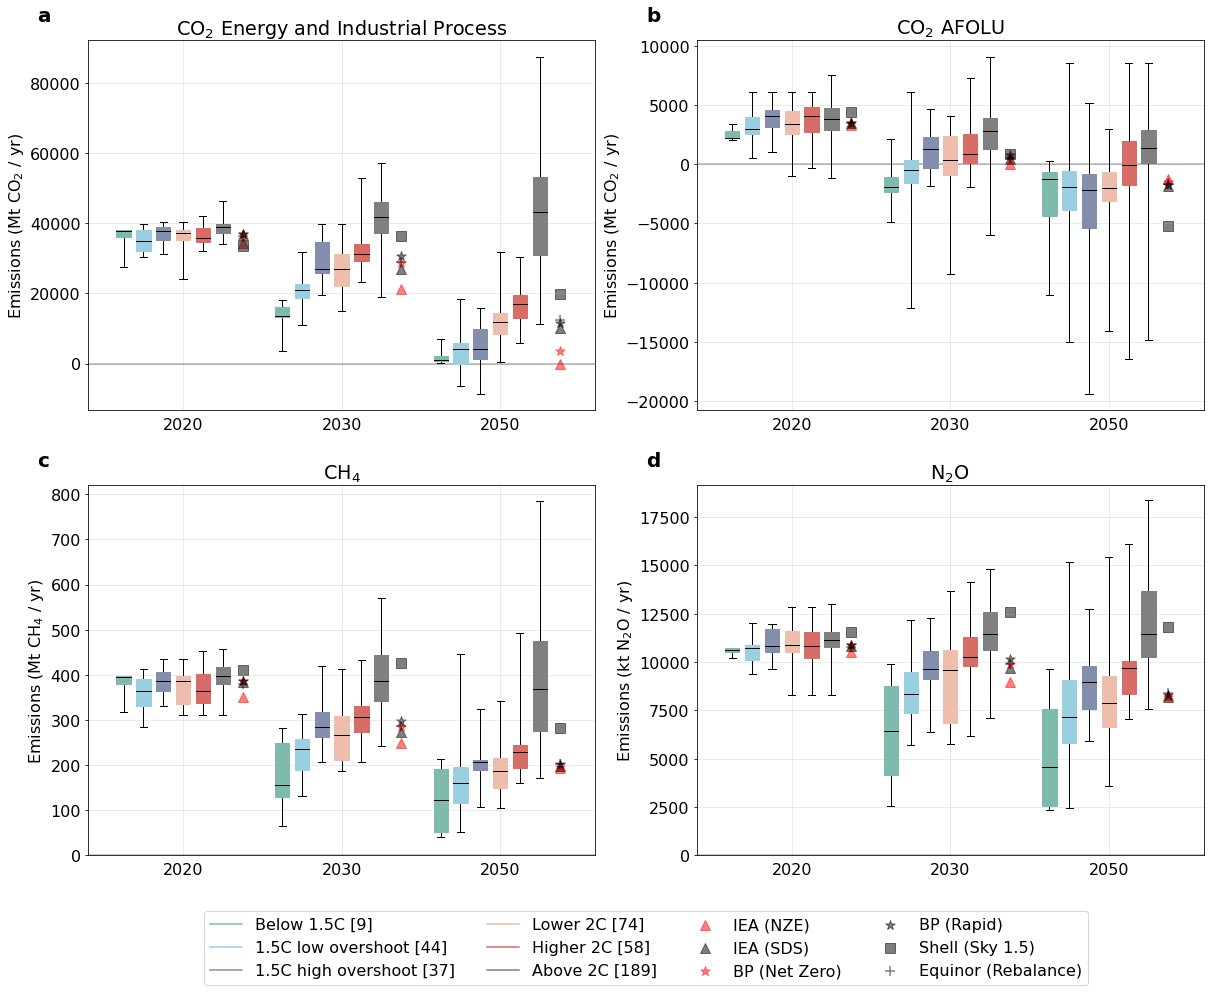

In [14]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

i = j = k = 0 

for var, ylab,title in vars_to_plot:
    if i > 1:
        i = 0
        j = 1
    
    boxplot_of_variable(
        ax[j,i],
        var,
        ylab,
        legend=False
    )

    ax[j,i].set_title(title)

    # Add text annotation 
    ax[j,i].text(-0.1, 1.05, string.ascii_lowercase[k], transform= ax[j,i].transAxes,
    size = 20, weight="bold")

    # Include 0 where necessary
    up = ax[j,i].get_ylim()[1]
    lo = np.minimum(ax[j,i].get_ylim()[0],0)
    ax[j,i].set_ylim(lo,up)

    ax[j,i].axhline(0, color = "black", alpha=0.3)

    i += 1
    k += 1


ax[1,0].legend(loc='center', ncol=4, bbox_to_anchor = (1.1, -0.25))

In [15]:
fig.savefig(
    os.path.join('figures', 'fig3_infilled_gas_multi_panel.png'),
    dpi=450,
    bbox_inches='tight'
)

In [16]:
fig.savefig(
    os.path.join('figures', 'fig3_infilled_gas_multi_panel.svg'),
    dpi=800,
    bbox_inches='tight'
)

# Calculate statistics for the main body of text 

In [17]:
filters_iam = [
    (('SR15','Below 1.5C'),{'category':['Below 1.5C']}),
    (('SR15','1.5C low overshoot'),{'category':['1.5C low overshoot']}),
    (('SR15','1.5C high overshoot'),{'category':['1.5C high overshoot']}),
    (('SR15','Lower 2C'),{'category':['Lower 2C']}),
    (('SR15','Higher 2C'),{'category':['Higher 2C']}),
    (('SR15','Above 2C'),{'category':['Above 2C']})
]

In [18]:
years = [2010, 2030, 2050]

In [19]:
stats_iam = pyam.Statistics(
    df = sr15_data,
    filters = filters_iam,
    rows = True
)

In [20]:
def add_stats_magnitude(stats, var_list, header, df, years):
    """Helper function to add stats for magnitude"""
    _df = df.filter(variable=var_list)
    for v in var_list:
        _df.require_variable(v, exclude_on_fail=True)
        _for_stats = _df.filter(variable=v, year = years).timeseries()
        stats.add(_for_stats, header=header, row=v)

In [21]:
for var, _, row in vars_to_plot:
    add_stats_magnitude(
        stats_iam, 
        [var],
        'Emissions', 
        sr15_data, 
        years    
    )

pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|Energy and Industrial Processes`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|AFOLU`
pyam.core - INFO: All scenarios have the required variable `Emissions|CH4`
pyam.core - INFO: All scenarios have the required variable `Emissions|N2O`


In [22]:
summary = stats_iam.summarize(center='median', interquartile=True, custom_format='{:.0f}')
summary = (
    summary
    .swaplevel(0, 2, axis=0).swaplevel(1, 2, axis=0)
    .sort_index(axis=0, level=0, sort_remaining=False)
)
summary

count  \
median (interquartile range)                                                   
Emissions|CH4                                 SR15 Below 1.5C              9   
                                                   1.5C low overshoot     44   
                                                   1.5C high overshoot    37   
                                                   Lower 2C               74   
                                                   Higher 2C              58   
                                                   Above 2C              189   
Emissions|CO2|AFOLU                           SR15 Below 1.5C              9   
                                                   1.5C low overshoot     44   
                                                   1.5C high overshoot    37   
                                                   Lower 2C               74   
                                                   Higher 2C              58   
                                                   Above 2C              189   
Emissions|CO2|Energy and Industrial Processes SR15 Below 1.5C              9   
                                                   1.5C low overshoot     44   
                                                   1.5C high overshoot    37   
                                                   Lower 2C               74   
                                                   Higher 2C              58   
                                                   Above 2C              189   
Emissions|N2O                                 SR15 Below 1.5C              9   
                                                   1.5C low overshoot     44   
                                                   1.5C high overshoot    37   
                                                   Lower 2C               74   
                                                   Higher 2C              58   
                                                   Above 2C              189   

                                                                                   Emissions  \
median (interquartile range)                                                            2010   
Emissions|CH4                                 SR15 Below 1.5C                 372 (372, 372)   
                                                   1.5C low overshoot         372 (372, 372)   
                                                   1.5C high overshoot        372 (372, 372)   
                                                   Lower 2C                   372 (372, 372)   
                                                   Higher 2C                  372 (372, 372)   
                                                   Above 2C                   372 (372, 372)   
Emissions|CO2|AFOLU                           SR15 Below 1.5C              3827 (3827, 3827)   
                                                   1.5C low overshoot      3827 (3827, 3827)   
                                                   1.5C high overshoot     3827 (3827, 3827)   
                                                   Lower 2C                3827 (3827, 3827)   
                                                   Higher 2C               3827 (3827, 3827)   
                                                   Above 2C                3827 (3827, 3827)   
Emissions|CO2|Energy and Industrial Processes SR15 Below 1.5C           32727 (32727, 32727)   
                                                   1.5C low overshoot   32727 (32727, 32727)   
                                                   1.5C high overshoot  32727 (32727, 32727)   
                                                   Lower 2C             32727 (32727, 32727)   
                                                   Higher 2C            32727 (32727, 32727)   
                                                   Above 2C             32727 (32727, 32727)   
Emissions|N2O                                 SR15 Below 1.5C         

# Summary stats for the institutional scenarios 

In [23]:
filters_inst = [
    ('EQW',{'model':'eqw'}),
    ('RMS',{'model':'rms'}),
    ('QRW',{'model':'qrw'})
]

In [24]:
stats_inst = pyam.Statistics(
    df = inst_data, 
    filters = filters_inst, 
    rows = True 
)

In [25]:
vars_to_plot = [
    ('Emissions|CO2|Energy and Industrial Processes', 'Emissions (Mt CO$_2$ / yr)', 'CO2 Energy and Industrial Process'),
    ('Emissions|CO2|AFOLU', 'Emissions (Mt CO$_2$ / yr)', 'CO2 AFOLU'),
    ('Emissions|CH4', 'Emissions (Mt CH$_4$ / yr)', 'CH4'),
    ('Emissions|N2O', 'Emissions (kt N$_2$O / yr)', 'N2O'), 
    ('Emissions|BC', 'Emissions (Mt BC / yr)', 'BC'), 
    ('Emissions|OC', 'OC/yr', 'OC')
]

In [26]:
for scen, _, _,_ in marker_categories:
    _data = inst_data.filter(scenario = scen)
    for var, _, header in vars_to_plot:
        add_stats_magnitude(
            stats_inst,
            [var],
            scen, 
            _data,
            [2030,2050]
        )

pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|Energy and Industrial Processes`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|AFOLU`
pyam.core - INFO: All scenarios have the required variable `Emissions|CH4`
pyam.core - INFO: All scenarios have the required variable `Emissions|N2O`
pyam.core - INFO: All scenarios have the required variable `Emissions|BC`
pyam.core - INFO: All scenarios have the required variable `Emissions|OC`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|Energy and Industrial Processes`
pyam.core - INFO: All scenarios have the required variable `Emissions|CO2|AFOLU`
pyam.core - INFO: All scenarios have the required variable `Emissions|CH4`
pyam.core - INFO: All scenarios have the required variable `Emissions|N2O`
pyam.core - INFO: All scenarios have the required variable `Emissions|BC`
pyam.core - INFO: All scenarios have the required variable `Emissions|OC`
pyam.core - INFO: All scenar

In [27]:
summary = stats_inst.summarize(center='median', interquartile=True, custom_format='{:.0f}')
summary = (
    summary
    .swaplevel(0, 1, axis=0)
    .sort_index(axis=0, level=0, sort_remaining=False)
)
summary.to_excel(
    'tables/t3_inst_method_compare.xlsx'
)

In [28]:
summary

count NZ2021         \
median (interquartile range)                              2030   2050   
Emissions|BC                                  EQW            5      2   
                                              RMS            5      5   
                                              QRW            6      4   
Emissions|CH4                                 EQW          217    112   
                                              RMS          255    190   
                                              QRW          248    193   
Emissions|CO2|AFOLU                           EQW        -1196  -7698   
                                              RMS         2261   1857   
                                              QRW           19  -1272   
Emissions|CO2|Energy and Industrial Processes EQW        21283      0   
                                              RMS        21283      0   
                                              QRW        21283      0   
Emissions|N2O                                 EQW         7329   5490   
                                              RMS         9042   9404   
                                              QRW         8974   8287   
Emissions|OC                                  EQW           23      8   
                                              RMS           27     23   
                                              QRW           28     20   

                                                  SDS_2020        Net_Zero  \
median (interquartile range)                          2030   2050     2030   
Emissions|BC                                  EQW        6      4        6   
                                              RMS        5      3        7   
                                              QRW        6      4        6   
Emissions|CH4                                 EQW      261    190      275   
                                              RMS      259    210      283   
                                              QRW      273    199      284   
Emissions|CO2|AFOLU                           EQW       59  -2022      309   
                                              RMS      381  -2024     -103   
                                              QRW      422  -1841      537   
Emissions|CO2|Energy and Industrial Processes EQW    26824  10219    28516   
                                              RMS    26824  10219    28516   
                                              QRW    26824  10219    28516   
Emissions|N2O                                 EQW     9250   7948     9657   
                                              RMS     9460   8830     9939   
                                              QRW     9674   8214     9877   
Emissions|OC                                  EQW       25     19       27   
                                              RMS       23     17       27   
                                              QRW       28     20       28   

                                                          Rapid         \
median (interquartile range)                        2050   2030   2050   
Emissions|BC                                  EQW      3      6      4   
                                              RMS      4      7      4   
                                              QRW      4      6      4   
Emissions|CH4                                 EQW    146    288    199   
                                              RMS    214    296    220   
                                              QRW    195    298    201   
Emissions|CO2|AFOLU                           EQW  -3897    659  -1711   
                                              RMS  -4766    207  -2423   
                                              QRW  -1498    748  -1746   
Emissions|CO2|Energy and Industrial Processes EQW   3685  30793  11587   
                                              RMS   3685  30793  11587   
                                              QRW   3685  30793  1

# Total Kyoto GHG figure 

In [29]:
kyoto_ghg = [ 
    "Emissions|CO2|Energy and Industrial Processes", 
    "Emissions|CO2|AFOLU", 
    "Emissions|CH4", 
    "Emissions|SF6", 
    "Emissions|N2O", 
    "Emissions|C2F6", 
    "Emissions|C6F14", 
    "Emissions|HFC*"
]

In [30]:
for i, source in enumerate(infill_data_set):
    source_path = os.path.join(
        '..','output','{}_infilled_data.xlsx'.format(source)
    )
    if i == 0:
        inst_data = pyam.IamDataFrame(source_path)
    else:
        inst_data = inst_data.append(
            pyam.IamDataFrame(source_path)
        )

pyam.core - INFO: Reading file ../output/bp_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/shell_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/weo_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/equinor_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators
pyam.core - INFO: Reading file ../output/ieasr15_infilled_data.xlsx
pyam.core - INFO: Reading meta indicators


In [31]:
inst_data_kyoto = inst_data.filter(
    variable = kyoto_ghg, 
    model = "qrw"
)

In [32]:
inst_data_kyoto_mtco2 = convert_units_to_MtCO2_equiv(inst_data_kyoto, metric_name = 'AR4GWP100')

In [33]:
inst_data_kyoto_mtco2.convert_unit(
    current = "Mt CO2/yr", 
    to = "Mt CO2-equiv/yr", 
    inplace = True 
)

In [34]:
inst_kyoto_ghg = inst_data_kyoto_mtco2.aggregate(
    variable = "Emissions|Kyoto GHG (AR4-GWP100)", 
    components = kyoto_ghg
).filter(variable = "Emissions|Kyoto GHG (AR4-GWP100)", year = range(2020,2110,10))

In [35]:
inst_kyoto_ghg.filter(scenario = ["BAU", "STEPS_2020"],keep = False).to_excel("tables/si_total_ghg_comparison.xlsx")

# Add the quantile for shell afolu

This is to support the statement: 
>Most infilled scenarios cluster in the interquartile range of the high-overshoot and 2°C scenarios, with the reported 2050 value from Shell a high outlier and implying a heavy reliance on land-based CDR that goes well beyond most of the low- and high- overshoot pathways


In [36]:
search_value = inst_data.filter(
    scenario = "Sky-1.5", 
    model = "qrw", 
    variable = "Emissions|CO2|AFOLU", 
    year = 2050
).data["value"][0]

In [37]:
search_distribution = sr15_data.filter(
    category = ["Below 1.5C", "1.5C*"],
    variable = "Emissions|CO2|AFOLU",
    year = 2050    
).data["value"]

In [38]:
stats.percentileofscore(search_distribution, search_value)

22.22222222222222